In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM

In [2]:
# read email data 
def read_data(filename):    
    # filename: string of the filename
    f = open(filename, "r")
    data = []
    for line in f:
        line = line.strip().split(',')
        line = list(map(float,line))
        data.append(line)
    return pd.DataFrame(data)

# read names 
def read_names(filename):
    f = open(filename,'r')
    names = []
    start_read = False
    for line in f:
        line = line.strip()
        if line and start_read:
            names.append(line.split(':')[0])
        if line.startswith('1, 0'):
            start_read = True
    names.append('spam')
    return names

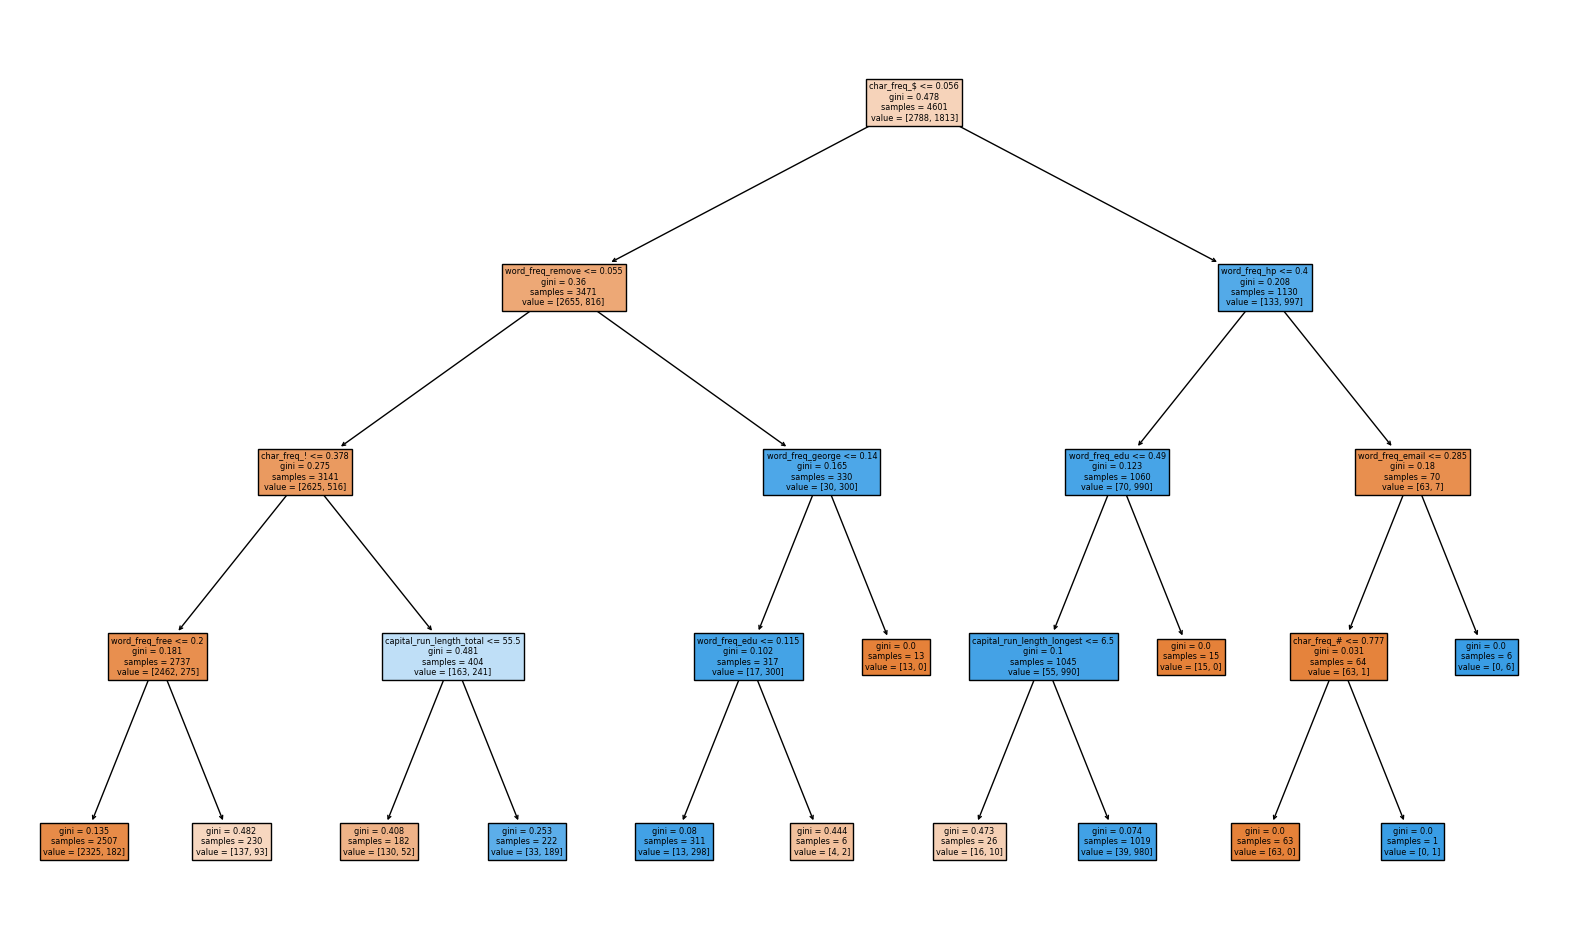

Random Forest Classifier error:  0.034744842562432154
Decision Tree Classifier error:  0.0684039087947883


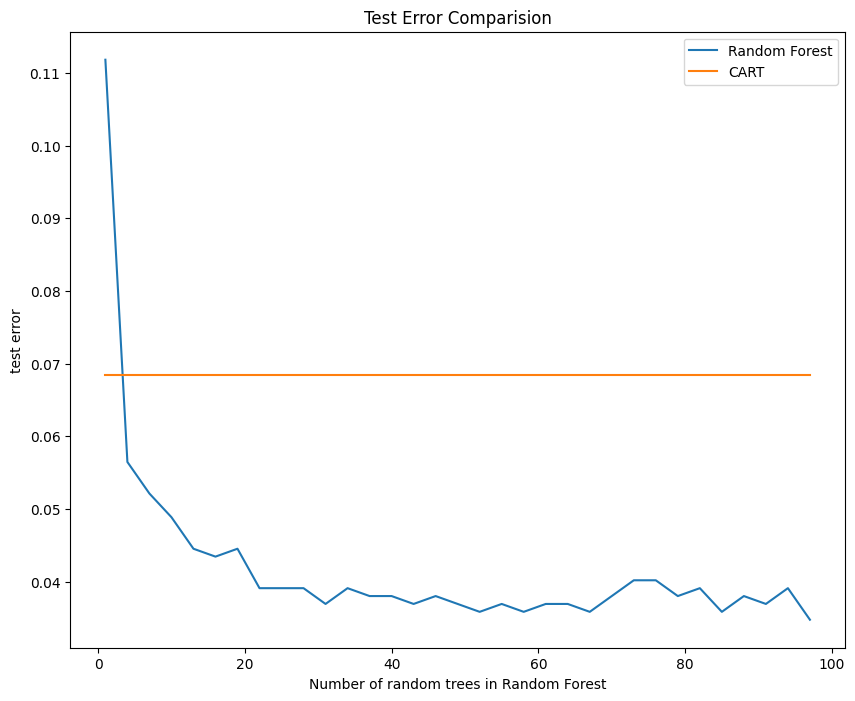

The test error of One-class SVM:  0.46796959826275786


In [23]:
f = open('spambase.data', "r")
data = []
for line in f:
    line = line.strip().split(',')
    line = list(map(float,line))
    data.append(line)
df = pd.DataFrame(data)

f = open('spambase.names','r')
names = []
start_read = False
for line in f:
    line = line.strip()
    if line and start_read:
        names.append(line.split(':')[0])
    if line.startswith('1, 0'):
        start_read = True
names.append('spam')
df.columns =names


X = df.drop('spam', axis=1)
y = df['spam']

# decision tree classifier
clf_tree = tree.DecisionTreeClassifier(max_depth = 4)
clf_tree.fit(X, y)
plt.figure(figsize = (20,12))
tree.plot_tree(clf_tree,filled = True,feature_names = df.columns[:-1])

plt.show()

# data partition
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# random forest classifier
clf_forest = RandomForestClassifier(random_state=10)
clf_forest.fit(X_train,y_train)
forest_accuracy = clf_forest.score(X_test,y_test)
print('Random Forest Classifier error: ', 1 -  forest_accuracy)


clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_train,y_train)
tree_accuracy = clf_tree.score(X_test,y_test)
print('Decision Tree Classifier error: ', 1 -  tree_accuracy)


test_errors = []
for num_trees in range(1,100,3):
    model = RandomForestClassifier(n_estimators = num_trees, random_state=0)
    model.fit(X_train, y_train)
    score = model.score(X_test,y_test)
    test_errors.append([num_trees, 1 - score])
test_errors = np.array(test_errors)

tree_test_error = [1 - tree_accuracy] * len(test_errors)


fig, ax = plt.subplots(figsize = (10,8))
ax.plot(test_errors[:,0], test_errors[:,1], label = 'Random Forest')
ax.plot(test_errors[:,0], tree_test_error, label = 'CART')
plt.legend()
plt.title('Test Error Comparision')
plt.xlabel('Number of random trees in Random Forest')
plt.ylabel('test error')
plt.show()



## One-class SVM
# extract nonspam emails from the training data
X_train_nonspam = X_train[y_train == 0]

# train a one-class SVM using RBF kernel
clf = OneClassSVM(kernel = 'rbf').fit(X_train_nonspam)
y_test_pred = clf.predict(X_test)

# inliers are nonspam emails
y_test_pred[y_test_pred == 1] = 0
# outliers are spam emails
y_test_pred[y_test_pred == -1] = 1

one_class_svm_test_error = sum(y_test_pred != y_test)/len(y_test)
print('The test error of One-class SVM: ',one_class_svm_test_error)

In [17]:

clf = OneClassSVM(kernel = 'rbf').fit(X_train_nonspam)
ytest_pred = clf.predict(X_test)
ytest_pred[ytest_pred == 1] = 0
ytest_pred[ytest_pred == -1] = 1
osvm_error = sum(ytest_pred != y_test)/len(y_test)
osvm_error



0.46796959826275786

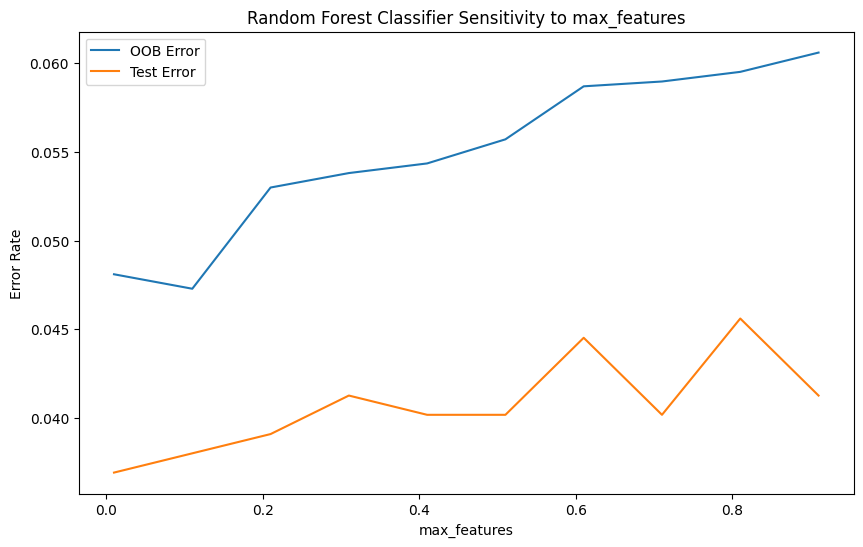

In [42]:
# Define a range of values for max_features
max_features_values = np.arange(0.01,1,.1)

# Initialize lists to store OOB and test errors
oob_errors = []
test_errors = []

# Fit random forest classifiers for each max_features value
for max_features in max_features_values:
    # Create and fit the random forest classifier
    clf = RandomForestClassifier(max_features=max_features, oob_score=True, random_state=42)
    clf.fit(X_train, y_train)

    # Append OOB error to the list
    oob_errors.append(1 - clf.oob_score_)

    # Append test error to the list
    test_errors.append(1 - clf.score(X_test, y_test))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, oob_errors, label='OOB Error')
plt.plot(max_features_values, test_errors, label='Test Error')
plt.title('Random Forest Classifier Sensitivity to max_features')
plt.xlabel('max_features')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

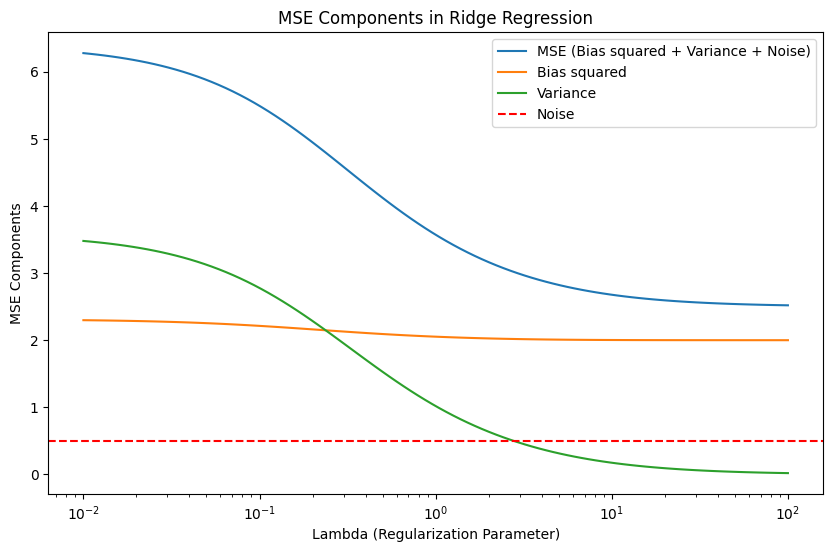

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Given values
x_train = np.array([0.15, 1.1])
x_test = np.array([1.5])
true_beta = np.array([-1, 1])
sigma_squared = 0.5

# Generate a range of lambda values
lambda_values = np.logspace(-2, 2, 100)

# Initialize arrays to store MSE components
mse_bias_squared = np.zeros_like(lambda_values)
mse_variance = np.zeros_like(lambda_values)
mse_noise = sigma_squared

# Ridge regression formula
for i, lambda_val in enumerate(lambda_values):
    # Design matrix
    X_train_design = np.vstack([np.ones_like(x_train), x_train]).T
    X_test_design = np.vstack([np.ones_like(x_test), x_test]).T

    # Ridge regression estimates
    beta_hat = np.linalg.inv(X_train_design.T @ X_train_design + lambda_val * np.identity(2)) @ X_train_design.T @ true_beta

    # Bias term
    bias_term = true_beta - np.mean(beta_hat, axis=0)

    # Variance term
    variance_term = np.trace(np.linalg.inv(X_train_design.T @ X_train_design + lambda_val * np.identity(2)))

    # MSE components
    mse_bias_squared[i] = np.sum(bias_term**2)
    mse_variance[i] = variance_term

# Total MSE
mse_total = mse_bias_squared + mse_variance + mse_noise

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogx(lambda_values, mse_total, label='MSE (Bias squared + Variance + Noise)')
plt.semilogx(lambda_values, mse_bias_squared, label='Bias squared')
plt.semilogx(lambda_values, mse_variance, label='Variance')
plt.axhline(y=mse_noise, color='r', linestyle='--', label='Noise')
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('MSE Components')
plt.title('MSE Components in Ridge Regression')
plt.legend()
plt.show()


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Given data
X_train = np.array([0.15, 1.1]).reshape(-1, 1)
y_train = -1 + 1 * X_train + np.random.normal(scale=np.sqrt(0.5), size=X_train.shape[0])

X_test = np.array([1]).reshape(-1, 1)
y_test = -1 + 1 * X_test  # True value without noise for testing

# Define a range of values for the regularization parameter (alpha)
alphas = np.logspace(-6, 6, 13)

# Train Ridge regression models for different values of alpha
mse_values = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# Plot the results
plt.plot(alphas, mse_values, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Parameter (alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE as a function of Regularization Parameter')
plt.show()


ValueError: y_true and y_pred have different number of output (1!=2)